# TF-IDF serialization debugging and possible tuning

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from recommenders.models.tfidf.tfidf_utils import TfidfRecommender
import pickle
import psycopg2

/Users/joshuamason/opt/anaconda3/envs/data_gandalf_v2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Before running this notebook:
1. Create a PostgreSQL database with the following options:\
    dbname="training_database",\
    user="postgres",\
    password="default",\
    host="localhost",\
    port="5432"

2. From the root directory of this system, run the following command:\
`psql -U postgres -f data_system/data_storage/pg_dump.sql training_database`

This will create a PostgreSQL database with all the metadata in the SQL dump file (pg_dump.sql).

Now, we will connect to that database and extract all the metadata into a pandas data frame.

In [2]:
# Connect to the database with metadata
conn = psycopg2.connect(
    dbname="training_database",
    user="postgres",
    password="default",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()
cursor.execute('SELECT * from dataset')

# Create pandas data frame with metadata
metadata = DataFrame(cursor.fetchall(), columns=['UID', 'Topic', 'Title', 'Description', 'Source', 
                                                 'Tags', 'Licenses', 'Col_names', 'Row_count', 'Col_count', 
                                                 'Entry_count', 'Null_count', 'Usability'])
# why is each sports dataset duplicated three times???
metadata = metadata.drop_duplicates(subset="Title", keep="first").reset_index(drop=True) 
metadata.head()


,UID,Topic,Title,Description,Source,Tags,Licenses,Col_names,Row_count,Col_count,Entry_count,Null_count,Usability
0,245,sports,2022 Game Winner Sports Betting Data,### Context\nA dear friend of mine has a sport...,kaggle,"{games,brazil,sports,gambling,python}","{""Attribution 4.0 International (CC BY 4.0)""}","{Data,Entrada,FunÃ§Ã£o,Fundamento,Investimento...",3691,45,27454,91,0.941176
1,246,sports,Find the Sports (Object Detection),I have used alot of Kaggle Datasets and I want...,kaggle,"{sports,""computer science""}",{CC-BY-SA-4.0},"{ImageID,XMin,YMin,XMax,YMax,Labels,OriginalUR...",6538,21,47887,0,0.882353
2,247,sports,Forbes Highest Paid Athletes 1990-2020,### Context\n\nHere is a completel list of the...,kaggle,{sports},{CC0-1.0},"{S.NO,Name,Nationality,""Current Rank"",""Previou...",301,8,2408,24,0.823529
3,248,sports,H&M Sports Apparel Data Set(9k+),The H&M Sports Apparel Data Set is a comprehen...,kaggle,"{global,sports,""clothing and accessories"",begi...",{CC0-1.0},"{Name_of_product,category,""price_of_product(in...",9146,8,73168,0,1.000000
4,249,sports,Men's Professional Basketball,"This dataset contains stats on players, coache...",kaggle,{basketball},{other},"{abbrev_type,code,full_name,year,coachID,award...",21821,156,394013,59750,0.852941


Here is some information about the metadata pulled in:

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UID          47 non-null     int64  
 1   Topic        47 non-null     object 
 2   Title        47 non-null     object 
 3   Description  47 non-null     object 
 4   Source       47 non-null     object 
 5   Tags         47 non-null     object 
 6   Licenses     47 non-null     object 
 7   Col_names    47 non-null     object 
 8   Row_count    47 non-null     int64  
 9   Col_count    47 non-null     int64  
 10  Entry_count  47 non-null     int64  
 11  Null_count   47 non-null     int64  
 12  Usability    47 non-null     float64
dtypes: float64(1), int64(5), object(7)
memory usage: 4.9+ KB


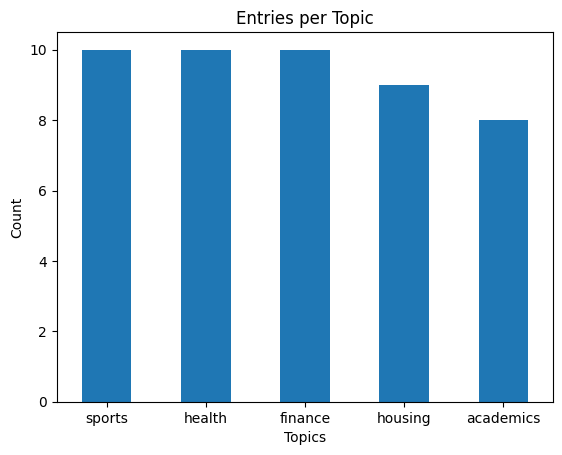

In [4]:
topic_counts = metadata['Topic'].value_counts()

topic_counts.plot(kind='bar')
plt.title('Entries per Topic')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [5]:
all_tags = metadata['Tags'].tolist()
all_tags = [tag for tags_list in all_tags for tag in tags_list]
unique = set(all_tags)
num_tags= len(unique)

print(f"Number of unique tags: {num_tags}")

Number of unique tags: 31


### 2. Instantiate the recommender

These are the following tokenization methods available out-of-the-box with this implementation:

| tokenization_method | Description                                                                                                                      |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------|
| 'none'              | No tokenization is applied. Each word is considered a token.                                                                     |
| 'nltk'              | Simple stemming is applied using NLTK.                                                                                           |
| 'bert'              | HuggingFace BERT word tokenization ('bert-base-cased') is applied.                                                               |
| 'scibert'           | SciBERT word tokenization ('allenai/scibert_scivocab_cased') is applied.<br>This is recommended for scientific journal articles. |

<i>Source: [Microsoft Recommender](https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/tfidf_covid.ipynb)</i>

In [6]:
# TODO: Recommender breaks if another tokenization method is used
recommender = TfidfRecommender(id_col='UID', tokenization_method='scibert')

### 3. Prepare text for use in the TF-IDF model

Here we will...

In [7]:
# Assign columns to clean and combine
metadata = metadata.astype(str) # combined columns have to all be strings
metadata = metadata.applymap(lambda x: x.lower())

# For now, we will use all columns except the UID
cols_to_clean = metadata.columns.tolist()
cols_to_clean.remove("UID") 

clean_col = 'cleaned_text'
df_clean = recommender.clean_dataframe(metadata, cols_to_clean, clean_col)
df_clean.head()

,UID,Topic,Title,Description,Source,Tags,Licenses,Col_names,Row_count,Col_count,Entry_count,Null_count,Usability,cleaned_text
0,245,sports,2022 game winner sports betting data,### context\na dear friend of mine has a sport...,kaggle,"{games,brazil,sports,gambling,python}","{""attribution 4.0 international (cc by 4.0)""}","{data,entrada,funã§ã£o,fundamento,investimento...",3691,45,27454,91,0.9411764705882353,sports 2022 game winner sports betting data c...
1,246,sports,find the sports (object detection),i have used alot of kaggle datasets and i want...,kaggle,"{sports,""computer science""}",{cc-by-sa-4.0},"{imageid,xmin,ymin,xmax,ymax,labels,originalur...",6538,21,47887,0,0.8823529411764706,sports find the sports object detection i have...
2,247,sports,forbes highest paid athletes 1990-2020,### context\n\nhere is a completel list of the...,kaggle,{sports},{cc0-1.0},"{s.no,name,nationality,""current rank"",""previou...",301,8,2408,24,0.8235294117647058,sports forbes highest paid athletes 19902020 ...
3,248,sports,h&m sports apparel data set(9k+),the h&m sports apparel data set is a comprehen...,kaggle,"{global,sports,""clothing and accessories"",begi...",{cc0-1.0},"{name_of_product,category,""price_of_product(in...",9146,8,73168,0,1.0,sports hm sports apparel data set9k the hm spo...
4,249,sports,men's professional basketball,"this dataset contains stats on players, coache...",kaggle,{basketball},{other},"{abbrev_type,code,full_name,year,coachid,award...",21821,156,394013,59750,0.8529411764705882,sports mens professional basketball this datas...


In [8]:
# Tokenize text with tokenization_method specified in class instantiation
tf, vectors_tokenized = recommender.tokenize_text(df_clean, text_col=clean_col)

In [9]:
tf

TfidfVectorizer(min_df=0, ngram_range=(1, 3), stop_words='english')

In [10]:
vectors_tokenized

0     sports 202 ##2 game win ##ner sports bet ##tin...
1     sports find the sports object detection i have...
2     sports forb ##es highest paid athletes 1990 ##...
3     sports h ##m sports app ##arel data set ##9 ##...
4     sports men ##s professional bas ##ket ##ball t...
5     sports nf ##l scores and bet ##ting data conte...
6     health healthy lifestyle cities report 202 ##1...
7     sports online sports bet ##ting online sports ...
8     sports political donation ##s by am ##eric ##a...
9     sports sports car prices dataset this dataset ...
10    sports sports st ##adium locations content con...
11    academic ##s academic ##score ##s ka ##gg ##le...
12    academic ##s global crypt ##o currency price d...
13    academic ##s global human trafficking abstract...
14    academic ##s global inflation dataset 1970 ##2...
15    academic ##s post recommendations dataset buil...
16    academic ##s survey academic ##s to cite this ...
17    academic ##s times world university rankin

### 4. Recommend articles using TF-IDF

In [11]:
# Fit the TF-IDF vectorizer
recommender.fit(tf, vectors_tokenized)

In [12]:
# (DOES NOT WORK, UNABLE TO SERIALIZE RECOMMENDATIONS ATTRIBUTE) Serialize model
# model_path = Path("../../backend/models/v2_model.pkl")
# with open(model_path, 'wb') as file:
#     pickle.dump(recommender, file)

In [13]:
# Get recommendations
top_k_recommendations = recommender.recommend_top_k_items(df_clean, k=10)

In [14]:
# full recommendation list
full_rec_list = recommender.recommendations
len(full_rec_list)

47

In [15]:
recommendations_path = Path("../../backend/models/recommendations.pkl")
with open(recommendations_path, 'wb') as file:
    pickle.dump(full_rec_list, file)

In our recommendation table, each row represents a single recommendation.

- **UID** corresponds to the article that is being used to make recommendations from.
- **rec_rank** contains the recommdation's rank (e.g., rank of 1 means top recommendation).
- **rec_score** is the cosine similarity score between the query article and the recommended article.
- **rec_cord_uid** corresponds to the recommended article.

In [16]:
article_of_interest = '245'
print('Number of recommended articles for ' + article_of_interest + ': ' + str(len(full_rec_list[article_of_interest])))

Number of recommended articles for 245: 46


In [17]:
metadata[metadata.UID == article_of_interest]

,UID,Topic,Title,Description,Source,Tags,Licenses,Col_names,Row_count,Col_count,Entry_count,Null_count,Usability
0,245,sports,2022 game winner sports betting data,### context\na dear friend of mine has a sport...,kaggle,"{games,brazil,sports,gambling,python}","{""attribution 4.0 international (cc by 4.0)""}","{data,entrada,funã§ã£o,fundamento,investimento...",3691,45,27454,91,0.9411764705882353


In [18]:
# Optionally view tokens
tokens = recommender.get_tokens()
# Preview 10 tokens
print(list(tokens.keys())[:10])
# Preview just the first 10 stop words sorted alphabetically
stop_words = list(recommender.get_stop_words())
stop_words.sort()
print(stop_words[:10])

['sports', '202', 'game', 'win', 'ner', 'bet', 'ting', 'data', 'context', 'ar']
['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost']


In [19]:
# Final Recs
cols_to_keep = cols_to_clean
recommender.get_top_k_recommendations(metadata,article_of_interest,cols_to_keep)
# TODO: why cant display UID??

,rank,similarity_score,Topic,Title,Description,Source,Tags,Licenses,Col_names,Row_count,Col_count,Entry_count,Null_count,Usability
0,1,0.136549,sports,nfl scores and betting data,### context\n\nnational football league histor...,kaggle,"{sports,gambling}",{cc-by-nc-sa-4.0},"{stadium_name,stadium_location,stadium_open,st...",13952,41,236668,28093,1.0
1,2,0.096973,sports,online sports betting,# online sports betting\n### a state-by-state ...,kaggle,"{sports,gambling}",{other},"{year,unsheltered,sheltered,""unnamed: 0"",""new ...",306,65,3195,944,0.9411764705882353
2,3,0.041816,finance,finance company loan data,### the data set has been taken from\nhttps://...,kaggle,{finance},{unknown},"{loan_id,loan_status,gender,married,dependents...",1348,27,13120,233,0.6470588235294118
3,4,0.038516,finance,yahoo finance apple inc. (aapl),### context\n\nthis is historical data which c...,kaggle,"{business,finance,marketing,""exploratory data ...",{copyright-authors},"{date,open,high,low,close,""adj close"",volume}",321,21,2247,0,0.9411764705882353
4,5,0.038439,health,ghana health facilities,## context\nthis dataset is provided as part o...,kaggle,"{healthcare,""earth and nature"",health,""social ...",{dbcl-1.0},"{region,district,facilityname,type,town,owners...",5231,11,34473,201,0.8823529411764706
5,6,0.037572,sports,sports car prices dataset,this dataset contains information about the pr...,kaggle,"{beginner,intermediate,tabular,regression,""ret...","{""attribution 4.0 international (cc by 4.0)""}","{""ï»¿car make"",""car model"",year,""engine size (...",1007,8,8056,13,1.0
6,7,0.033889,academics,survey academics,\nto cite this data set: j. berengueres and p....,kaggle,"{business,education,""social science"",psychology}",{odbl-1.0},"{ï»¿stress,hindex,tenured,subjective.happyness...",6517,54,121398,49406,0.9705882352941176
7,8,0.033519,sports,sports stadium locations,### content\n\ncontains the latitude and longi...,kaggle,"{football,baseball,basketball,sports,tabular}",{cc0-1.0},"{ï»¿team,league,division,lat,long}",151,5,755,0,0.9411764705882353
8,9,0.030545,sports,h&m sports apparel data set(9k+),the h&m sports apparel data set is a comprehen...,kaggle,"{global,sports,""clothing and accessories"",begi...",{cc0-1.0},"{name_of_product,category,""price_of_product(in...",9146,8,73168,0,1.0
9,10,0.030414,sports,find the sports (object detection),i have used alot of kaggle datasets and i want...,kaggle,"{sports,""computer science""}",{cc-by-sa-4.0},"{imageid,xmin,ymin,xmax,ymax,labels,originalur...",6538,21,47887,0,0.8823529411764706


In [ ]:
full_rec_list

{'1': [(0.1468160851392342, '2'),
  (0.1359126015351822, '4'),
  (0.09983522742920584, '5'),
  (0.09763022228914314, '6'),
  (0.07913184161330096, '8'),
  (0.07374285570465379, '7'),
  (0.061417411373365406, '9'),
  (0.03457619216149142, '10'),
  (0.022604881033718802, '33'),
  (0.019772308034270332, '49'),
  (0.019490744915321295, '21'),
  (0.019205428741174337, '11'),
  (0.018812769330634804, '17'),
  (0.01738853007945406, '41'),
  (0.015163072132233038, '12'),
  (0.014884828792053377, '31'),
  (0.014814132545724761, '22'),
  (0.014340242885032096, '29'),
  (0.013982145142032087, '50'),
  (0.01253261533495018, '36'),
  (0.012315028111303786, '3'),
  (0.011153193479166839, '27'),
  (0.010116869429567403, '43'),
  (0.009619735478694018, '44'),
  (0.009495640245302691, '19'),
  (0.009129556595903998, '16'),
  (0.008155730553045155, '32'),
  (0.007953515578930382, '25'),
  (0.007839871641238984, '48'),
  (0.007534630161927507, '38'),
  (0.00733393464422093, '34'),
  (0.007089619278749053